# Customized routing based on random and Thomson sampling across multiple regions on Amazon Bedrock

This section of the notebook implements a system to optimize API call latency across multiple AWS regions. Two strategies are used: **Thompson Sampling** (TS) and **Random Selection** to decide which API endpoint to use based on past latency observations.



### Set retries to 1
- this is so we can implement a custom retry mechanism (TODO)
- Also, this is easier to test and report benefits

In [1]:
import boto3
from botocore.config import Config

config = Config(
   retries = {
      'max_attempts': 1,
      'mode': 'standard'
   }
)

Use a large article to summarize as a test case...

In [3]:
with open('cross-region-test/article.txt','r') as f:
    article = f.read()

In [7]:
max_prompt = "Write a 1000 word summary of the article below:\n\nArticle\n" + article + "\n\n Note: remember to stick to a 1000 word summary of the above article. Not more or less."

### Common wrapper to call Haiku using converse API on Amazon Bedrock. This can be changed to a model of your choice

In [9]:
def call_api(prompt: str, region_name='us-east-1'):
    bedrock_runtime = boto3.client('bedrock-runtime', config=config, region_name=region_name)
    
    modelId = 'anthropic.claude-3-haiku-20240307-v1:0'
    try:
        response = bedrock_runtime.converse(
            modelId=modelId,
            system=[{
                "text": "You are a helpful AI assistant with accurate answers to user questions. Pay attention to the word limit if provided."
            }],
            messages=[{
                "role": "user",
                "content": [{"text": max_prompt}]
            }],
            inferenceConfig={"maxTokens": 1000}
        )
        
        lat = response['metrics']['latencyMs']
        res = response['output']['message']['content'][0]
        stat = response['ResponseMetadata']['HTTPStatusCode']
        
        # Return latency and response only if status code is 200
        if stat == 200:
            return res, lat, stat
        else:
            # Penalize with high latency for failed requests
            return None, float('inf'), stat

    except Exception as e:
        print(e)
        # Return a high latency on failure (e.g., API request exception)
        return None, float('inf'), 500  # Simulate failure with status 500


In [11]:
# call_api(prompt=max_prompt)

# Main implementation

## 1. Importing Required Libraries
- `numpy` and `pandas` are used for numerical computations and data management.
- `time` is used to track the execution time of API calls.

## 2. Defining API Regions and Initializing Parameters
- A list of AWS regions (`us-east-1`, `us-west-2`, etc.) serves as different API endpoints.
- Each region is initialized with prior mean (`mu`) and variance (`sigma^2`) values for latency estimation.
- Separate tracking is maintained for both **Thompson Sampling** and **Random Selection** strategies.

## 3. Thompson Sampling for API Selection
Thompson Sampling is used to dynamically select the API region with the lowest estimated latency.  
- **Sampling**: A latency value is drawn from a normal distribution for each API.
- **Selection**: The API with the lowest sampled latency (within a 20% tolerance) is chosen.
- **Updating Statistics**: After each call, the estimated mean and variance are updated using a decaying average.

## 4. Random API Selection Strategy
- A region is randomly selected for API calls.
- Statistics (mean and variance) are updated based on observed latencies.
- This serves as a baseline comparison against Thompson Sampling.

## 5. Handling API Failures
- If an API call fails, the system penalizes the region by assigning a latency twice the last successful response time.
- This prevents repeatedly choosing unreliable regions.

## 6. Simulating API Calls and Performance Tracking
- The `simulate_calls` function runs multiple API calls using either **Thompson Sampling** or **Random Selection**.
- It tracks:
  - **Observed latencies**
  - **Failure counts**
  - **Total execution time**

By comparing the results, we can determine which strategy provides the best performance for API latency optimization.


In [12]:
from tqdm import tqdm

Note below that the calls are not restricted to a common region like CRIS, and any number of regions may be included in the `regions` list

In [13]:
import numpy as np
import pandas as pd
import time  # For tracking wall time

# Define the region options as different API endpoints
regions = ['us-east-1', 'us-west-2', 'ap-south-1', 'ap-southeast-2', 
           'ap-northeast-1', 'ca-central-1', 'eu-central-1', 'eu-west-2']

num_apis = len(regions)

# Initialize priors for each API (mean and variance)
api_mu_ts = [1.0] * num_apis  # Start with a prior mean latency of 1 second for TS
api_var_ts = [1.0] * num_apis  # Start with a prior variance of 1 second for TS

api_mu_random = [1.0] * num_apis  # Start with a prior mean latency of 1 second for Random
api_var_random = [1.0] * num_apis  # Start with a prior variance of 1 second for Random

# Track the number of observations for each API
api_count_ts = [0] * num_apis
api_count_random = [0] * num_apis

total_latency_ts = [0.0] * num_apis
total_latency_random = [0.0] * num_apis

# Track the last successful latency for failure handling (for TS)
last_successful_latency = [3.0] * num_apis  # Assume a reasonable initial latency in seconds

# Tolerance for latency differences (e.g., 20%)
latency_tolerance = 0.20

# Thompson Sampling to pick the API based on its latency distribution
def thompson_sampling():
    sampled_latencies = [
        np.random.normal(api_mu_ts[i], np.sqrt(api_var_ts[i])) for i in range(num_apis)
    ]
    
    # Find the minimum sampled latency
    min_latency = min(sampled_latencies)
    
    # Select an API within the tolerance range (e.g., 20% higher latency still acceptable)
    candidates = [
        i for i in range(num_apis) if sampled_latencies[i] <= min_latency * (1 + latency_tolerance)
    ]
    
    # If no candidates within the tolerance, fall back to the API with the minimum sampled latency
    if not candidates:
        selected_api = np.argmin(sampled_latencies)  # Index of the API with the minimum latency
    else:
        selected_api = np.random.choice(candidates)
    
    return selected_api


# Update the statistics of each API based on observed latency (for TS)
def update_api_stats_ts(selected_api, observed_latency):
    api_count_ts[selected_api] += 1
    total_latency_ts[selected_api] += observed_latency
    
    # Update the mean (mu) and variance (sigma^2) using decaying average
    n = api_count_ts[selected_api]
    mu_prev = api_mu_ts[selected_api]
    alpha = 0.3  # Weight for the decay
    api_mu_ts[selected_api] = alpha * observed_latency + (1 - alpha) * mu_prev
    
    if n > 1:
        sigma_prev = api_var_ts[selected_api]
        api_var_ts[selected_api] = ((n - 1) * sigma_prev + (observed_latency - api_mu_ts[selected_api])**2) / n

# Update stats for Random case
def update_api_stats_random(selected_api, observed_latency):
    api_count_random[selected_api] += 1
    total_latency_random[selected_api] += observed_latency
    
    # Update the mean (mu) and variance (sigma^2) using decaying average
    n = api_count_random[selected_api]
    mu_prev = api_mu_random[selected_api]
    alpha = 0.3  # Weight for the decay
    api_mu_random[selected_api] = alpha * observed_latency + (1 - alpha) * mu_prev
    
    if n > 1:
        sigma_prev = api_var_random[selected_api]
        api_var_random[selected_api] = ((n - 1) * sigma_prev + (observed_latency - api_mu_random[selected_api])**2) / n

# API call simulation with the different regions
def call_api_with_thompson_sampling(prompt: str):
    selected_api = thompson_sampling()
    region = regions[selected_api]
    
    try:
        # Call the actual API with the selected region
        res, observed_latency, status_code = call_api(prompt, region_name=region)
        observed_latency /= 1000.0  # Convert latency to seconds
        
        # If the status is successful, update the stats
        if status_code == 200:
            last_successful_latency[selected_api] = observed_latency  # Update last successful latency
            update_api_stats_ts(selected_api, observed_latency)
        else:
            raise Exception("API failed")
    
    except Exception:
        # Handle failed requests by penalizing the latency (double the last successful latency)
        observed_latency = last_successful_latency[selected_api] * 2
        update_api_stats_ts(selected_api, observed_latency)
    
    return observed_latency, status_code

# API call simulation for Random strategy
def call_api_with_random(prompt: str):
    selected_api = np.random.choice(num_apis)
    region = regions[selected_api]
    
    try:
        # Call the actual API with the selected region
        res, observed_latency, status_code = call_api(prompt, region_name=region)
        observed_latency /= 1000.0  # Convert latency to seconds
        
        if status_code == 200:
            update_api_stats_random(selected_api, observed_latency)
        else:
            raise Exception("API failed")
    
    except Exception:
        # Handle failed requests by penalizing the latency (double last successful latency)
        observed_latency = 6.0  # Set a default high penalty (6 seconds)
        update_api_stats_random(selected_api, observed_latency)
    
    return observed_latency, status_code

# Simulate API calls for comparison and track wall time
def simulate_calls(strategy, num_calls=100):
    latencies = []
    failures = 0
    
    start_time = time.time()
    
    for _ in tqdm(range(num_calls)):
        if strategy == "thompson_sampling":
            observed_latency, status_code = call_api_with_thompson_sampling(max_prompt)
        else:
            observed_latency, status_code = call_api_with_random(max_prompt)
        
        # Track failures and latencies
        if status_code != 200:
            failures += 1
        latencies.append(observed_latency)
    
    total_time = time.time() - start_time  # Calculate the total wall time in seconds
    avg_latency = np.mean(latencies)
    
    return avg_latency, failures, total_time



In [14]:
%%time
# Run simulations for Thompson Sampling and Random strategies

# Increase number of calls for an actual test

num_calls = 10
avg_latency_ts, failures_ts, time_ts = simulate_calls(strategy="thompson_sampling", num_calls=num_calls)
avg_latency_random, failures_random, time_random = simulate_calls(strategy="random", num_calls=num_calls)



 50%|█████     | 5/10 [01:05<00:50, 10.14s/it]

An error occurred (ServiceUnavailableException) when calling the Converse operation (reached max retries: 1): Bedrock is unable to process your request.


100%|██████████| 10/10 [02:15<00:00, 13.55s/it]

CPU times: user 403 ms, sys: 39.6 ms, total: 443 ms
Wall time: 4min 36s


In [15]:
# Calculate throughput (requests per minute)
throughput_ts = num_calls / (time_ts / 60)
throughput_random = num_calls / (time_random / 60)

# Report results
print(f"Thompson Sampling: Avg Latency = {avg_latency_ts}, Failures = {failures_ts}, Throughput = {throughput_ts:.2f} requests/min")
print(f"Random Strategy: Avg Latency = {avg_latency_random}, Failures = {failures_random}, Throughput = {throughput_random:.2f} requests/min")

# Create separate DataFrames for Thompson Sampling and Random strategies
def display_api_statistics(api_mu, api_var, api_count):
    probabilities = [count / sum(api_count) if sum(api_count) > 0 else 0 for count in api_count]
    
    data = {
        'Region': regions,
        'Mean Latency (seconds)': api_mu,
        'Latency Variance (seconds^2)': api_var,
        'Hit Count': api_count,
        'Probability': probabilities
    }
    
    df = pd.DataFrame(data)
    return df

# Display final statistics for both strategies
statistics_df_ts = display_api_statistics(api_mu_ts, api_var_ts, api_count_ts)
statistics_df_random = display_api_statistics(api_mu_random, api_var_random, api_count_random)

# print("\nThompson Sampling Strategy Statistics:")
# print(statistics_df_ts)

# print("\nRandom Strategy Statistics:")
# print(statistics_df_random)


Thompson Sampling: Avg Latency = 13.6123, Failures = 0, Throughput = 4.26 requests/min
Random Strategy: Avg Latency = 13.4462, Failures = 1, Throughput = 4.43 requests/min


In [16]:
statistics_df_ts

,Region,Mean Latency (seconds),Latency Variance (seconds^2),Hit Count,Probability
0,us-east-1,5.15650,1.000000,1,0.1
1,us-west-2,4.95670,1.000000,1,0.1
2,ap-south-1,5.34352,9.134007,2,0.2
3,ap-southeast-2,4.21840,1.000000,1,0.1
4,ap-northeast-1,6.50662,11.150866,2,0.2
5,ca-central-1,4.48870,1.000000,1,0.1
6,eu-central-1,8.29750,1.000000,1,0.1
7,eu-west-2,5.04160,1.000000,1,0.1


In [17]:
statistics_df_random

,Region,Mean Latency (seconds),Latency Variance (seconds^2),Hit Count,Probability
0,us-east-1,8.99275,52.064551,2,0.2
1,us-west-2,1.00000,1.000000,0,0.0
2,ap-south-1,5.69974,13.277827,2,0.2
3,ap-southeast-2,6.79738,16.839872,2,0.2
4,ap-northeast-1,5.25580,21.173736,2,0.2
5,ca-central-1,1.00000,1.000000,0,0.0
6,eu-central-1,8.64040,1.000000,1,0.1
7,eu-west-2,4.64620,1.000000,1,0.1


<Axes: xlabel='Region'>

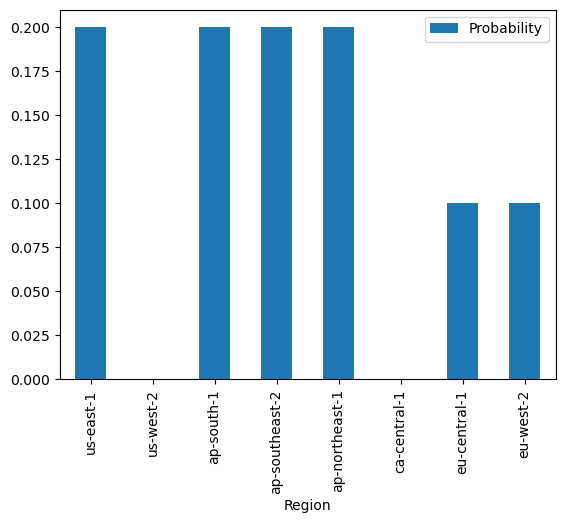

In [18]:
statistics_df_random.plot.bar(x='Region', y='Probability')

<Axes: xlabel='Region'>

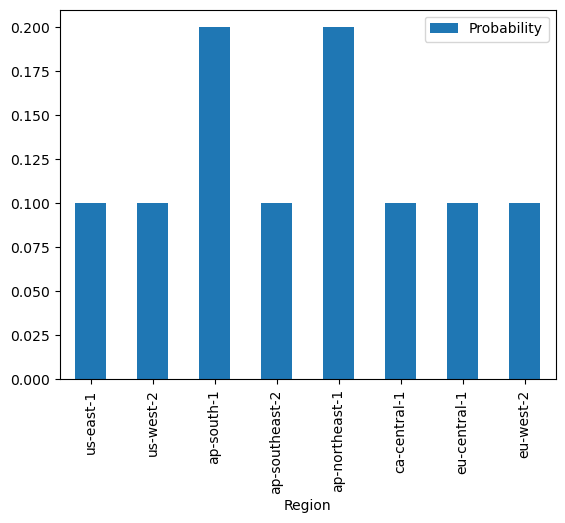

In [19]:
statistics_df_ts.plot.bar(x='Region', y='Probability')

# Compare to Amazon Bedrock Cross Region Inference

In the previous sections, we implemented custom strategies—**Thompson Sampling** and **Random Selection**—to optimize API call latency across multiple AWS regions. These methods involve manually selecting regions based on observed latencies and dynamically adjusting strategies to improve performance.

**Amazon Bedrock's Cross-Region Inference** offers a managed alternative to handle cross-region traffic distribution:

- **Inference Profiles**: Bedrock introduces system-defined inference profiles that abstract multiple AWS regions behind a unified model identifier. By specifying an inference profile in your API requests, Bedrock automatically routes traffic across the defined regions, managing unplanned traffic bursts and increasing throughput without manual intervention. :contentReference[oaicite:0]{index=0}

- **Throughput and Resilience**: Utilizing cross-region inference can provide up to double the default in-region quotas, enhancing resilience during peak demand periods. :contentReference[oaicite:1]{index=1}

**Key Differences**:

- **Manual vs. Automated Management**: Custom strategies require manual implementation and maintenance of region selection logic, whereas Bedrock's cross-region inference automates traffic distribution.

- **Scalability**: Bedrock's solution scales seamlessly with demand, leveraging AWS infrastructure to handle traffic bursts, while custom implementations may require additional resources to achieve similar scalability.

- **Complexity**: Implementing custom strategies adds complexity to your application code. In contrast, Bedrock's inference profiles simplify cross-region management by handling routing internally.

In summary, while custom cross-region strategies offer control over region selection and traffic management, Amazon Bedrock's cross-region inference provides a streamlined, automated approach to distribute inference requests across regions, enhancing throughput and resilience with minimal operational overhead.



In [20]:

import boto3
from botocore.config import Config

config = Config(
   retries = {
      'max_attempts': 1,
      'mode': 'standard'
   }
)

def call_api_cris(prompt: str, region_name='us-east-1'):
    bedrock_runtime = boto3.client('bedrock-runtime', config=config, region_name=region_name)
    
    modelId = 'us.anthropic.claude-3-haiku-20240307-v1:0'
    try:
        response = bedrock_runtime.converse(
            modelId=modelId,
            system=[{
                "text": "You are a helpful AI assistant with accurate answers to user questions. Pay attention to the word limit if provided."
            }],
            messages=[{
                "role": "user",
                "content": [{"text": max_prompt}]
            }],
            inferenceConfig={"maxTokens": 1000}
        )
        
        lat = response['metrics']['latencyMs']
        res = response['output']['message']['content'][0]
        stat = response['ResponseMetadata']['HTTPStatusCode']
        
        # Return latency and response only if status code is 200
        if stat == 200:
            return res, lat, stat
        else:
            # Penalize with high latency for failed requests
            return None, float('inf'), stat

    except Exception as e:
        # Return a high latency on failure (e.g., API request exception)
        return None, float('inf'), 500  # Simulate failure with status 500


In [21]:
def call_api_with_random_cris(prompt: str):
    selected_api = np.random.choice(num_apis)
    region = regions[selected_api]
    
    try:
        # Call the actual API with the selected region
        res, observed_latency, status_code = call_api_cris(prompt)
        observed_latency /= 1000.0  # Convert latency to seconds
        
        if status_code == 200:
            update_api_stats_random(selected_api, observed_latency)
        else:
            raise Exception("API failed")
    
    except Exception:
        # Handle failed requests by penalizing the latency (double last successful latency)
        observed_latency = 6.0  # Set a default high penalty (6 seconds)
        update_api_stats_random(selected_api, observed_latency)
    
    return observed_latency, status_code

# Simulate API calls for comparison and track wall time
def simulate_calls_cris(num_calls=100):
    latencies = []
    status_codes = []
    failures = 0
    
    start_time = time.time()
    
    for _ in tqdm(range(num_calls)):
        observed_latency, status_code = call_api_with_random_cris(max_prompt)
        
        # Track failures and latencies
        if status_code != 200:
            failures += 1
        latencies.append(observed_latency)
        status_codes.append(status_code)
        
    total_time = time.time() - start_time  # Calculate the total wall time in seconds
    avg_latency = np.mean(latencies)
    
    return avg_latency, failures, total_time, latencies, status_codes



In [22]:
%%time
# Run simulations for Thompson Sampling and Random strategies
num_calls = 10
avg_latency_cris, failures_cris, time_cris, latencies, status_codes = simulate_calls_cris(num_calls=num_calls)

100%|██████████| 10/10 [02:36<00:00, 15.66s/it]

CPU times: user 184 ms, sys: 5.15 ms, total: 189 ms
Wall time: 2min 36s


In [23]:
throughput_cris = num_calls / (time_cris / 60)


print(f"US CRIS: Avg Latency = {avg_latency_cris}, Failures = {failures_cris}, Throughput = {throughput_cris:.2f} requests/min")


US CRIS: Avg Latency = 15.6326, Failures = 0, Throughput = 3.83 requests/min


In [24]:
np.var(latencies)

1.904591640000001

In [28]:
failures_cris

0

In [29]:
df = pd.DataFrame(data={
        'Region': ['Random', 'US CRIS','TS'],
        'Mean Latency (seconds)': [avg_latency_random, avg_latency_cris, avg_latency_ts],
        'Latency Variance (seconds^2)': [statistics_df_random['Latency Variance (seconds^2)'].mean(),np.var(latencies),statistics_df_ts['Latency Variance (seconds^2)'].mean()],
        'Throughput (RPM)': [throughput_random, throughput_cris, throughput_ts]
    })

df.style.set_caption("Random routing vs. CRIS vs TS: 5000 in -1000 out tokens. For TS, regions considered are "+', '.join(regions))

,Region,Mean Latency (seconds),Latency Variance (seconds^2),Throughput (RPM)
0,Random,13.446200,13.419498,4.427516
1,US CRIS,15.632600,1.904592,3.831459
2,TS,13.612300,3.285609,4.256542


In [30]:
status_codes

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200]

## Conclusion

This notebook explored different strategies for optimizing API call latency across multiple AWS regions. By implementing **Thompson Sampling** and **Random Selection**, we demonstrated how adaptive decision-making can improve response times while balancing failure handling.

We also compared these methods to **Amazon Bedrock's Cross-Region Inference**, which provides an automated approach for distributing inference requests across regions. While custom strategies offer greater control and fine-tuning, Bedrock simplifies scalability and resilience with minimal operational overhead.

For workloads requiring precise control over region selection, Thompson Sampling remains a strong choice. However, for applications prioritizing ease of use and built-in AWS optimizations, Bedrock's inference profiles provide a compelling alternative. Ultimately, the best approach depends on specific business needs, performance goals, and infrastructure constraints.
